# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)  

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

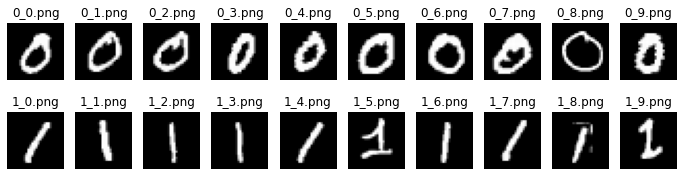

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

# QUESTION: SHOULD WE RETRIEVE ONLY THE OUTER CONTOUR FOR THE ZEROS OR ALSO THE INNER ONE? IF ALSO THE INNER ONE, HOW DO WE LINK THEM WHEN MAKING THE COMPLEX SIGNAL?

# QUESTION: OK TO USE CV FUNCTIONS TO DO EVERYTHING?

# Note: must find a good way to remove noise outside of digits from image. For now thresholding at 150 works fine.

In [3]:
import cv2 as cv
import numpy as np

def get_fourier_descriptor(image, n_coefficients_to_keep = 2):
    
    # Compute outer contours of image.
    _, contour, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contour = contour[0].squeeze()
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap = "gray")
    stub_im = np.zeros_like(image)
    for i,j in contour:
        stub_im[j,i] = 1
    ax[1].imshow(stub_im, cmap = "gray")
    plt.show()
    
    # Make complex signal from contour array.
    complex_contour_signal = contour[:, 0] + 1j * contour[:, 1]
    
    # Compute fourier coefficients.
    fourier_coefficients = np.fft.fft(complex_contour_signal)
    
    # To make fourier coefficient resistant to scaling, ratio between coefficients is used instead of actual magnitude.
    fourier_coefficients = fourier_coefficients / fourier_coefficients[0]  
    
    # To make fourier coefficient resistant to translation, first coefficient discarded.
    fourier_coefficients = fourier_coefficients[1:]
    
    # To make fourier coefficient resistant to rotation, phase is discarded.
    fourier_coefficients = np.abs(fourier_coefficients)  
    
    return fourier_coefficients[:n_coefficients_to_keep]


def pretreat_image(image):
    return (image > 150).astype(np.uint8)


def plot_fourier_descriptors(coefficients_digits_list, marker_digits_list, label_digits_list):
    assert(len(coefficients_digits_list) == len(marker_digits_list) == len(label_digits_list))
    
    for coefficients_digit, marker, label in zip(coefficients_digits_list, marker_digits_list, label_digits_list):
        plt.scatter(coefficients_digit[:, 0], coefficients_digit[:, 1], marker = marker, label = label)
        
    plt.legend()
    plt.show()

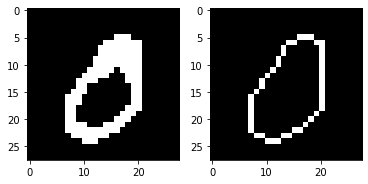

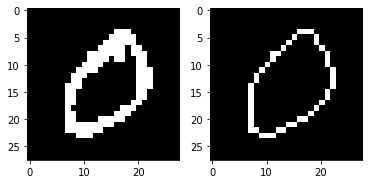

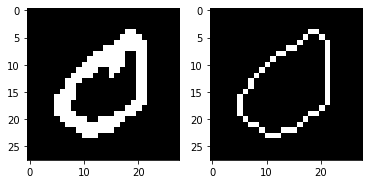

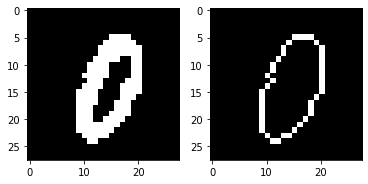

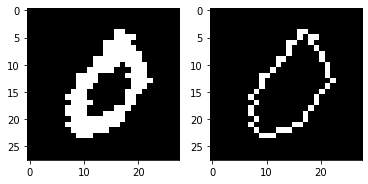

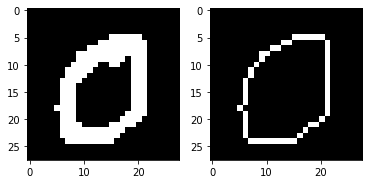

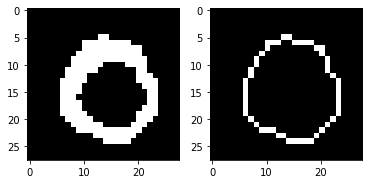

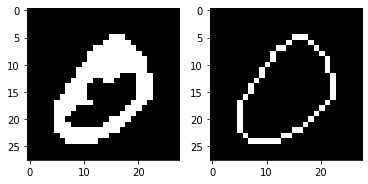

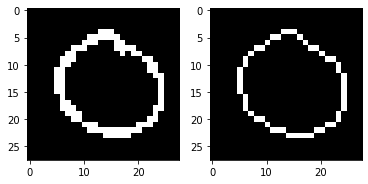

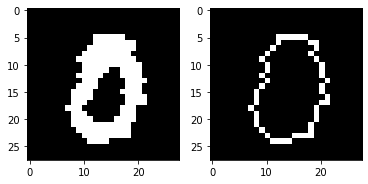

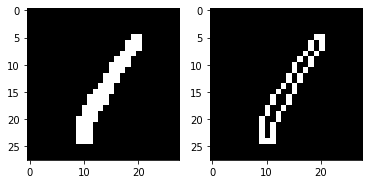

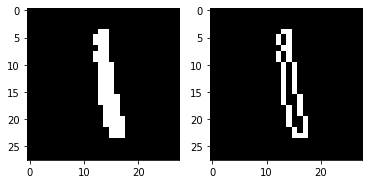

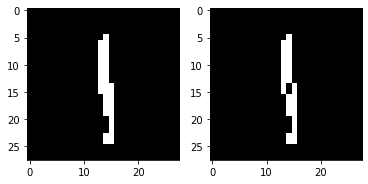

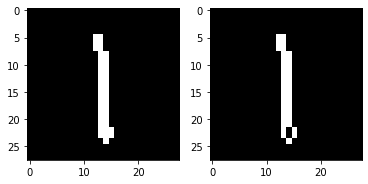

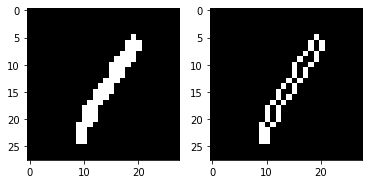

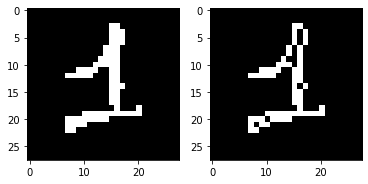

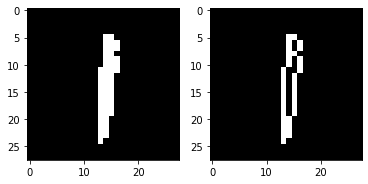

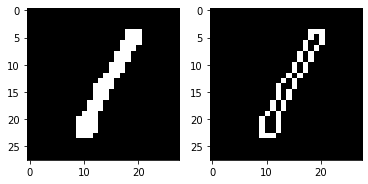

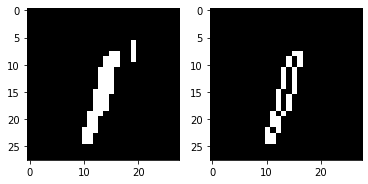

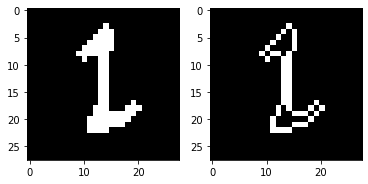

In [4]:
coefficients_zeros = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in zeros_im])
coefficients_ones  = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in ones_im])

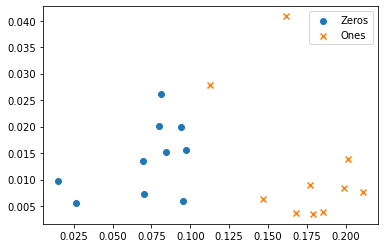

In [5]:
plot_fourier_descriptors([coefficients_zeros, coefficients_ones], ['o', 'x'], ["Zeros", "Ones"])

#### Discussion
- 


### 1.3 Additional method (5 pts)

In [66]:
import cv2
import numpy as np

# to check invariance we implement functions (that we will use throughout exercises) 
# https://opencv-python-tutroals.readthedocs.io/en/latest/-
# -py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
# that rotate/scale/translate

def rotate(img,deg):
    """
    desc: rotate object (technically here we rotate the whole 
    image with center of image being center of rotation, but 
    since background thresholded)
    #TODO implem limitation to not go outside of frame
    """
    rows,cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),deg,1)
    return cv2.warpAffine(img,M,(cols,rows))

def translate(img,dx,dy):
    """
    desc: translate object by translating full image
    #TODO implem limitation to not go outside of frame
    """
    rows,cols = img.shape
    M = np.float32([[1,0,dx],[0,1,dy]])
    return cv2.warpAffine(img,M,(cols,rows))

def scale(img,dx,dy):
    """
    desc: scaling object by scaling full image
    #TODO implem limitation to not go outside of frame
    """
    # note: INTER_CUBIC better for upsample
    # for downsample might be better to use INTER_AREA
    return cv2.resize(img,(dx*width, dy*height), interpolation = cv2.INTER_CUBIC)
    
# testing here
# ...

<b>Simple method</b>

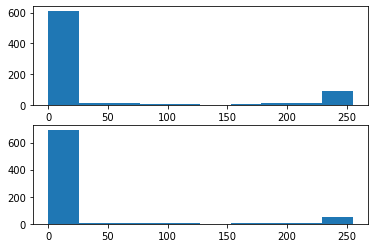

In [73]:
# Add your implementation and discussion
import seaborn as sns

clean_mask = lambda x: x>100
bin_img0 = clean_mask(zeros_im[0])
bin_img1 = clean_mask(ones_im[0])

x0,y0 = np.where(bin_img0==1)
x1,y1 = np.where(bin_img1==1)

fig, ax = plt.subplots(2)

ax[0].hist(zeros_im[0].reshape(-1))
ax[1].hist(ones_im[0].reshape(-1))

plt.show()

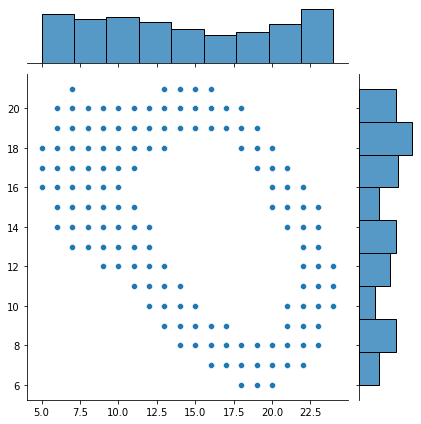

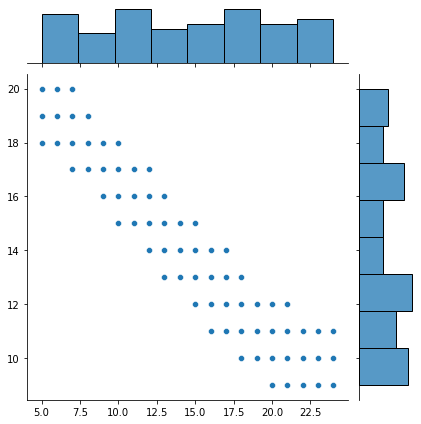

In [74]:
sns.jointplot(x=x0,y=y0)
sns.jointplot(x=x1,y=y1)

Need to extract the features from the created histograms shaping the number

#### Discussion
- 


<b>Hu moments method</b>

<i>We did no pre-processing yet, we will see what to do later.<i/>

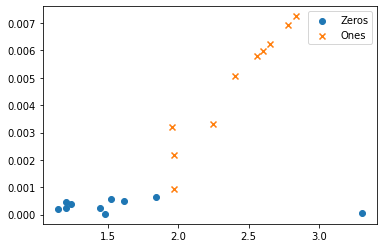

In [31]:
# Add your implementation and discussion
# https://www.pyimagesearch.com/2014/10/27/opencv-shape-descriptor-hu-moments-example/

# Hu Moments 
def feature_ext(img,n=2):
    """
    desc: gives the invariant features of an image 
    """
    m = cv2.moments(img)
    return cv2.HuMoments(m).flatten()[:2]

def plot_regiondesc(coefficients_digits_list,marker_digits_list, label_digits_list):
    for coefficients_digit, marker, label in zip(coefficients_digits_list, 
                                                 marker_digits_list, label_digits_list):
        plt.scatter(coefficients_digit[:, 0], coefficients_digit[:, 1], 
                    marker = marker, label = label)
        
    plt.legend()
    plt.show()


zero_features = np.asarray([feature_ext(img) for img in zeros_im])
one_features = np.asarray([feature_ext(img) for img in ones_im])
sample = np.concatenate((zero_features,one_features))
zero_features /= np.mean(sample)
one_features /= np.mean(sample)

plot_regiondesc([zero_features,one_features],['o', 'x'], ["Zeros", "Ones"])

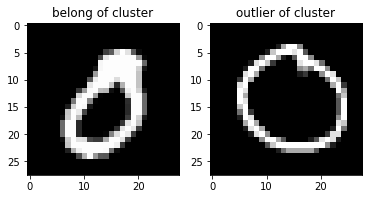

In [45]:
# plotting the outlier shown above graph 
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('belong of cluster')
ax[1].title.set_text('outlier of cluster')
ax[0].imshow(zeros_im[0],cmap='gray')
ax[1].imshow(zeros_im[-2],cmap='gray')
plt.show()

#### Discussion
- 


---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

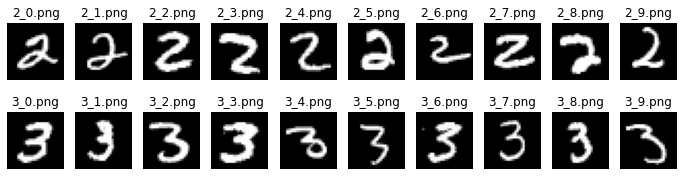

In [7]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

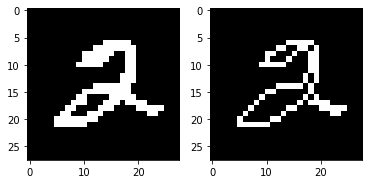

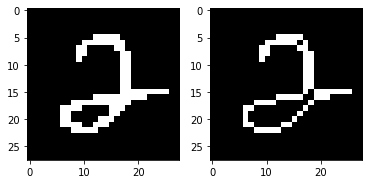

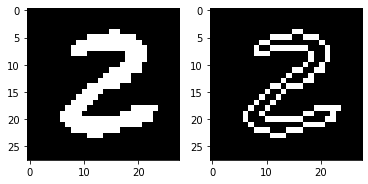

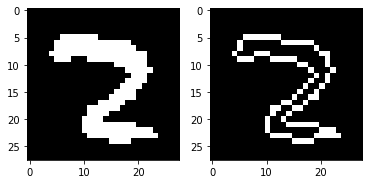

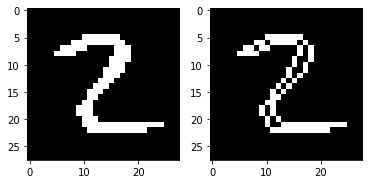

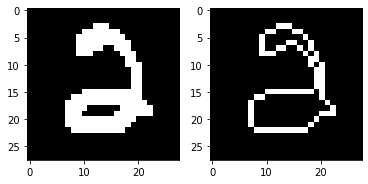

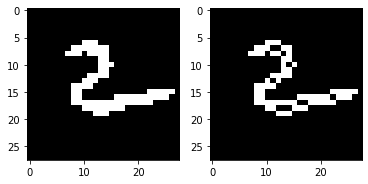

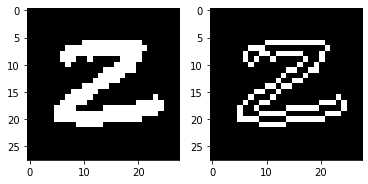

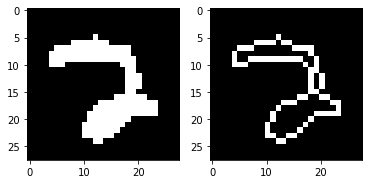

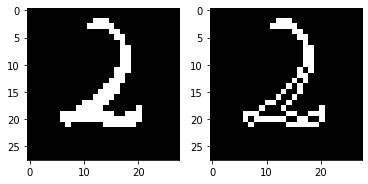

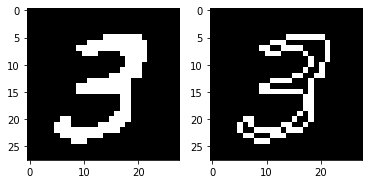

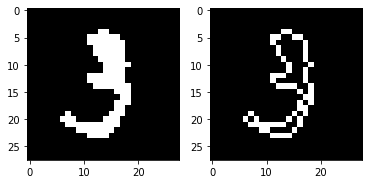

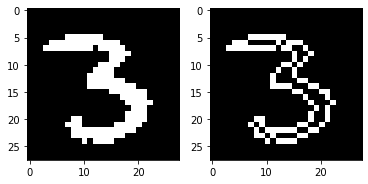

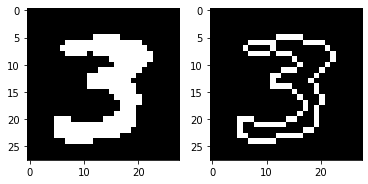

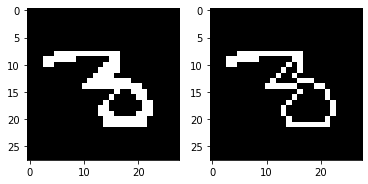

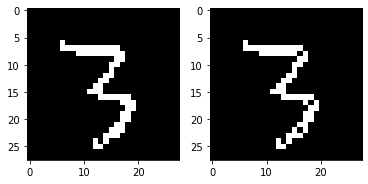

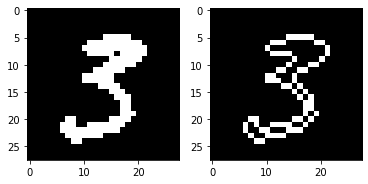

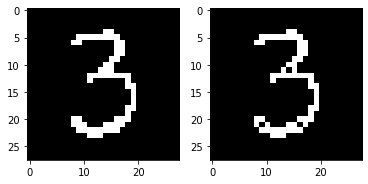

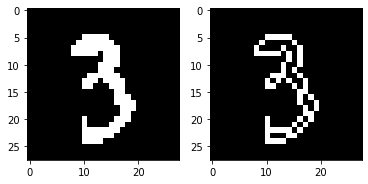

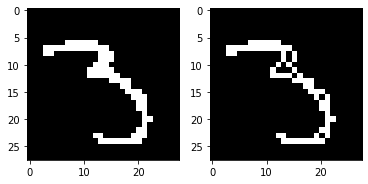

In [8]:
coefficients_twos   = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in twos_im])
coefficients_threes = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in threes_im])

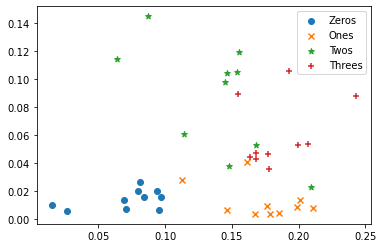

In [9]:
plot_fourier_descriptors([coefficients_zeros, coefficients_ones, coefficients_twos, coefficients_threes], 
                         ['o', 'x', '*', '+'], ["Zeros", "Ones", "Twos", "Threes"])